In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from scipy import signal
import wandb


/home/fernando/anaconda3/envs/SYDE_671/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and process data

In [5]:
# col_headers = np.load('../data/training_data/headers.npy')

x_train = np.load('../data/training_data/x_train_imp_no_jump.npy').astype('float32')


x_val = np.load('../data/val_data/x_val_imp_no_jump.npy').astype('float32')
x_test = np.load('../data/test_data/x_test_imp_no_jump.npy').astype('float32')

y_train = np.load('../data/training_data/y_train_imp_no_jump.npy').astype('float32')
y_val = np.load('../data/val_data/y_val_imp_no_jump.npy').astype('float32')
y_test = np.load('../data/test_data/y_test_imp_no_jump.npy').astype('float32')

In [10]:
import os 
print(os.getcwd())

/home/fernando/Documents/Graduate Studies/Python/599Project/model


In [7]:
feature_means = []
feature_stds = []

for feature_i in range(x_train.shape[2]):
    mean = x_train[:, :, feature_i].mean()
    std = x_train[:, :, feature_i].std()
    
    feature_means.append(mean)
    feature_stds.append(std)
    
    x_train[:, :, feature_i] -= mean
    x_train[:, :, feature_i] /= std
    print(std)
    x_val[:, :, feature_i] -= mean
    x_val[:, :, feature_i] /= std
    
    x_test[:, :, feature_i] -= mean
    x_test[:, :, feature_i] /= std

0.99999964
1.0
0.9999999
0.9999995
1.0000002
1.0000004
1.0
0.9999999
0.9999999
1.0000001
1.0
1.0000002
1.0000004
0.99999917
1.0000008
1.000001
0.99999934
0.9999998
0.9999998
1.0000002
1.0
1.0000002
1.0000004
0.9999998
0.99999976
0.99999964
1.0000004
0.9999999
0.99999976
0.99999994


In [ ]:
# Adding Noise
alpha = 0.15
x_train_2 = x_train +np.random.normal(0,alpha,x_train.shape)
x_train = numpy.concatenate((x_train_2, x_train, ), axis=0)

In [12]:
config = dict(
    model_name = 'base_imputate_no_jump_100_ep',
    windows_size = 5000,
    jump= 5000,
    epoch = 100,
    learning_rate = 1e-3,
    encoder_channels = (30,32,64,128,256,512),
    decoder_channels =  (30,32,64,128,256,512),
    batch_size = 16,
    amputate=True
)


## Dataloader

In [13]:
class FOGDataset(Dataset):
    def __init__(self, data_x, data_y):

        self.x = np.transpose(data_x, axes = (0,2,1))
        self.y = data_y
        
        self.length = self.x.shape[0]
        
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx, :, :])
        y = torch.tensor(self.y[idx])
        
        return x, y
    
    def __len__(self):
        return self.length

In [14]:
def create_dataloders(config):
    train_dataset = FOGDataset(x_train, y_train)
    val_dataset = FOGDataset(x_val, y_val)
    test_dataset = FOGDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size= config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size= config['batch_size'])
    return train_loader, val_loader, test_loader


## Training loop

In [15]:

def train_model(model,train_loader,val_loader,config):


    # model = CNN(17, 0)
    model.to(model.device)

    torch.manual_seed(0)
    np.random.seed(0)
    val_accuracy_save = 0
    n_epochs = config['epoch']
    for epoch in range(n_epochs):
        train_losses = []
        model.train()
        
        # Training
        for x, y in tqdm(train_loader):
            x = x.to(model.device)
            y = y.to(model.device)
            
            model.optimizer.zero_grad()
            y_hat = model(x)
            loss = model.loss_fn(y_hat, y)
            loss.backward()
            model.optimizer.step()
            
            train_losses.append(loss.item())
            
        val_losses = []
        val_outputs = []
        model.eval()
        
        # Validation
        for x, y in tqdm(val_loader):
            x = x.to(model.device)
            y = y.to(model.device)
            
            with torch.no_grad():
                y_hat = model(x)
                loss = model.loss_fn(y_hat, y)
                y_hat = torch.round(y_hat)
                
                val_losses.append(loss.item())
                val_outputs.append((y_hat == y).float().mean().cpu())
        train_loss = np.array(train_losses).mean()
        val_loss = np.array(val_losses).mean()
        val_accuracy = np.array(val_outputs).mean()
        wandb.log({"Epoch":epoch+1,
                   "Train Loss":train_loss,
                   "Validation Loss":val_loss,
                   "Validation Accuracy":val_accuracy},
                   step = epoch)
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, ' 
            f'Val Loss: {val_loss:.3f}, '
            f'Val Accuracy: {val_accuracy:.3f}')
        if val_accuracy>val_accuracy_save:
            torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': model.optimizer.state_dict(),
                'validation accuracy': val_accuracy}, 
                'checkpoints/'+config['model_name']+'.pth')


## Test Model

In [16]:
def test_model(model,test_loader):

    test_outputs = []
    targets = []
    model.eval()
    model.to(model.device)
    for i ,(x, y) in enumerate(tqdm(test_loader)):
        x = x.to(model.device)
        y = y.to(model.device)

        with torch.no_grad():
            y_hat = model(x)
            out = torch.round(y_hat)
        
        #test_outputs.append(y_hat)
            targets.append(y)
            test_outputs.append((out == y).float().mean().cpu())

            y = y[1,:].view(-1)
            y_hat = y_hat[1,:].view(-1)
            out = out[1,:].view(-1)
            fig = plt.figure()
            plt.plot(y.cpu())
            plt.plot(y_hat.cpu())
            plt.plot(out.cpu())
            plt.legend(['Target', 'Prediction','Output'])
            plt.ylim((0,1))
            wandb.log({"chart"+str(i): plt})
                    
    """sos = signal.butter(1, 1, 'lp', fs=5, output='sos')
    test_outputs = torch.cat(test_outputs, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()
    test_outputs = signal.sosfilt(sos, test_outputs)
    """

    test_accuracy = np.array(test_outputs).mean()
    wandb.log({"Test Accuracy":test_accuracy})
    print(f'Test Accuracy: {test_accuracy:.3f}')

    # torch.onnx.export(model,x,'model.onnx')
    # wandb.save(model,'model.onnx')
    


In [17]:


with wandb.init(project="SYDE_599_project", entity="fjpenaca",config = config):
    train_loader, val_loader, test_loader = create_dataloders(config)
    train_model(model,train_loader,val_loader,config)
    checkpoint = torch.load('checkpoints/'+config['model_name']+'.pth')
    model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.load_state_dict(checkpoint['model_state_dict'])
    test_model(model,test_loader)
    
# torch.save(model, 'model')

wandb: Currently logged in as: fjpenaca. Use `wandb login --relogin` to force relogin


  0%|          | 0/53 [00:00<?, ?it/s]/home/fernando/anaconda3/envs/SYDE_671/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Epoch: 1, Train Loss: 0.590, Val Loss: 0.546, Val Accuracy: 0.717


100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Epoch: 2, Train Loss: 0.488, Val Loss: 0.435, Val Accuracy: 0.809


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 3, Train Loss: 0.424, Val Loss: 0.453, Val Accuracy: 0.830


100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Epoch: 4, Train Loss: 0.383, Val Loss: 0.356, Val Accuracy: 0.842


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 5, Train Loss: 0.364, Val Loss: 0.344, Val Accuracy: 0.848


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 6, Train Loss: 0.339, Val Loss: 0.327, Val Accuracy: 0.863


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 7, Train Loss: 0.325, Val Loss: 0.373, Val Accuracy: 0.862


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 8, Train Loss: 0.324, Val Loss: 0.350, Val Accuracy: 0.863


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 9, Train Loss: 0.275, Val Loss: 0.286, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 10, Train Loss: 0.292, Val Loss: 0.370, Val Accuracy: 0.831


100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Epoch: 11, Train Loss: 0.267, Val Loss: 0.465, Val Accuracy: 0.867


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 12, Train Loss: 0.275, Val Loss: 0.307, Val Accuracy: 0.883


100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Epoch: 13, Train Loss: 0.263, Val Loss: 0.282, Val Accuracy: 0.891


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 14, Train Loss: 0.228, Val Loss: 0.366, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 15, Train Loss: 0.236, Val Loss: 0.327, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Epoch: 16, Train Loss: 0.219, Val Loss: 0.386, Val Accuracy: 0.855


100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch: 17, Train Loss: 0.234, Val Loss: 0.427, Val Accuracy: 0.862


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 18, Train Loss: 0.233, Val Loss: 0.280, Val Accuracy: 0.887


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 19, Train Loss: 0.191, Val Loss: 0.434, Val Accuracy: 0.883


100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Epoch: 20, Train Loss: 0.207, Val Loss: 0.351, Val Accuracy: 0.868


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 21, Train Loss: 0.210, Val Loss: 0.304, Val Accuracy: 0.880


100%|██████████| 12/12 [00:02<00:00,  5.11it/s]


Epoch: 22, Train Loss: 0.172, Val Loss: 0.317, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch: 23, Train Loss: 0.187, Val Loss: 0.310, Val Accuracy: 0.883


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 24, Train Loss: 0.191, Val Loss: 0.311, Val Accuracy: 0.891


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 25, Train Loss: 0.186, Val Loss: 0.343, Val Accuracy: 0.879


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 26, Train Loss: 0.153, Val Loss: 0.331, Val Accuracy: 0.892


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 27, Train Loss: 0.146, Val Loss: 0.361, Val Accuracy: 0.873


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 28, Train Loss: 0.148, Val Loss: 0.316, Val Accuracy: 0.874


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 29, Train Loss: 0.141, Val Loss: 0.386, Val Accuracy: 0.879


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 30, Train Loss: 0.137, Val Loss: 0.327, Val Accuracy: 0.876


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 31, Train Loss: 0.112, Val Loss: 0.367, Val Accuracy: 0.857


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 32, Train Loss: 0.108, Val Loss: 0.323, Val Accuracy: 0.875


100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Epoch: 33, Train Loss: 0.109, Val Loss: 0.353, Val Accuracy: 0.865


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 34, Train Loss: 0.125, Val Loss: 0.330, Val Accuracy: 0.891


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 35, Train Loss: 0.114, Val Loss: 0.449, Val Accuracy: 0.876


100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Epoch: 36, Train Loss: 0.113, Val Loss: 0.384, Val Accuracy: 0.885


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 37, Train Loss: 0.094, Val Loss: 0.411, Val Accuracy: 0.872


100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Epoch: 38, Train Loss: 0.096, Val Loss: 0.415, Val Accuracy: 0.859


100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Epoch: 39, Train Loss: 0.086, Val Loss: 0.381, Val Accuracy: 0.880


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 40, Train Loss: 0.103, Val Loss: 0.454, Val Accuracy: 0.843


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 41, Train Loss: 0.102, Val Loss: 0.350, Val Accuracy: 0.883


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 42, Train Loss: 0.083, Val Loss: 0.399, Val Accuracy: 0.880


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 43, Train Loss: 0.064, Val Loss: 0.411, Val Accuracy: 0.855


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 44, Train Loss: 0.083, Val Loss: 0.392, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 45, Train Loss: 0.067, Val Loss: 0.387, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 46, Train Loss: 0.082, Val Loss: 0.393, Val Accuracy: 0.870


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 47, Train Loss: 0.081, Val Loss: 0.362, Val Accuracy: 0.881


100%|██████████| 12/12 [00:02<00:00,  5.04it/s]


Epoch: 48, Train Loss: 0.068, Val Loss: 0.433, Val Accuracy: 0.868


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 49, Train Loss: 0.074, Val Loss: 0.409, Val Accuracy: 0.870


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 50, Train Loss: 0.056, Val Loss: 0.387, Val Accuracy: 0.888


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 51, Train Loss: 0.058, Val Loss: 0.405, Val Accuracy: 0.869


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 52, Train Loss: 0.056, Val Loss: 0.439, Val Accuracy: 0.884


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 53, Train Loss: 0.052, Val Loss: 0.529, Val Accuracy: 0.876


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 54, Train Loss: 0.051, Val Loss: 0.425, Val Accuracy: 0.880


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 55, Train Loss: 0.040, Val Loss: 0.442, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 56, Train Loss: 0.121, Val Loss: 0.412, Val Accuracy: 0.869


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 57, Train Loss: 0.059, Val Loss: 0.447, Val Accuracy: 0.884


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 58, Train Loss: 0.050, Val Loss: 0.409, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 59, Train Loss: 0.045, Val Loss: 0.488, Val Accuracy: 0.877


100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch: 60, Train Loss: 0.050, Val Loss: 0.437, Val Accuracy: 0.881


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 61, Train Loss: 0.050, Val Loss: 0.466, Val Accuracy: 0.877


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 62, Train Loss: 0.040, Val Loss: 0.465, Val Accuracy: 0.886


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 63, Train Loss: 0.034, Val Loss: 0.447, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 64, Train Loss: 0.029, Val Loss: 0.480, Val Accuracy: 0.879


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 65, Train Loss: 0.025, Val Loss: 0.486, Val Accuracy: 0.881


100%|██████████| 12/12 [00:02<00:00,  4.98it/s]


Epoch: 66, Train Loss: 0.018, Val Loss: 0.574, Val Accuracy: 0.884


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 67, Train Loss: 0.037, Val Loss: 0.488, Val Accuracy: 0.892


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 68, Train Loss: 0.041, Val Loss: 0.477, Val Accuracy: 0.884


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 69, Train Loss: 0.035, Val Loss: 0.494, Val Accuracy: 0.861


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 70, Train Loss: 0.029, Val Loss: 0.558, Val Accuracy: 0.881


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 71, Train Loss: 0.054, Val Loss: 0.464, Val Accuracy: 0.867


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 72, Train Loss: 0.041, Val Loss: 0.488, Val Accuracy: 0.868


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 73, Train Loss: 0.029, Val Loss: 0.498, Val Accuracy: 0.872


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 74, Train Loss: 0.020, Val Loss: 0.545, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch: 75, Train Loss: 0.021, Val Loss: 0.626, Val Accuracy: 0.851


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]


Epoch: 76, Train Loss: 0.035, Val Loss: 0.541, Val Accuracy: 0.886


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 77, Train Loss: 0.025, Val Loss: 0.503, Val Accuracy: 0.884


100%|██████████| 12/12 [00:02<00:00,  5.09it/s]


Epoch: 78, Train Loss: 0.028, Val Loss: 0.491, Val Accuracy: 0.880


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 79, Train Loss: 0.031, Val Loss: 0.522, Val Accuracy: 0.876


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 80, Train Loss: 0.031, Val Loss: 0.569, Val Accuracy: 0.872


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 81, Train Loss: 0.066, Val Loss: 0.619, Val Accuracy: 0.871


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 82, Train Loss: 0.032, Val Loss: 0.547, Val Accuracy: 0.867


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 83, Train Loss: 0.027, Val Loss: 0.515, Val Accuracy: 0.870


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 84, Train Loss: 0.026, Val Loss: 0.565, Val Accuracy: 0.872


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch: 85, Train Loss: 0.021, Val Loss: 0.598, Val Accuracy: 0.862


100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Epoch: 86, Train Loss: 0.021, Val Loss: 0.616, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch: 87, Train Loss: 0.019, Val Loss: 0.586, Val Accuracy: 0.877


100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch: 88, Train Loss: 0.011, Val Loss: 0.552, Val Accuracy: 0.885


100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch: 89, Train Loss: 0.014, Val Loss: 0.621, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch: 90, Train Loss: 0.020, Val Loss: 0.597, Val Accuracy: 0.870


100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch: 91, Train Loss: 0.023, Val Loss: 0.612, Val Accuracy: 0.876


100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch: 92, Train Loss: 0.022, Val Loss: 0.641, Val Accuracy: 0.882


100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Epoch: 93, Train Loss: 0.025, Val Loss: 0.732, Val Accuracy: 0.869


100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch: 94, Train Loss: 0.022, Val Loss: 0.589, Val Accuracy: 0.867


100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch: 95, Train Loss: 0.021, Val Loss: 0.583, Val Accuracy: 0.878


100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Epoch: 96, Train Loss: 0.020, Val Loss: 0.583, Val Accuracy: 0.877


100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch: 97, Train Loss: 0.028, Val Loss: 0.592, Val Accuracy: 0.875


100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Epoch: 98, Train Loss: 0.027, Val Loss: 0.576, Val Accuracy: 0.868


100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Epoch: 99, Train Loss: 0.021, Val Loss: 0.597, Val Accuracy: 0.874


100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Epoch: 100, Train Loss: 0.029, Val Loss: 0.648, Val Accuracy: 0.871


  0%|          | 0/12 [00:00<?, ?it/s]/home/fernando/anaconda3/envs/SYDE_671/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

100%|██████████| 12/12 [00:06<00:00,  1.74it/s]

Test Accuracy: 0.861


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁
Train Loss,█▆▅▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▇▇▇█▇████▇▇████▇▇▇▇█▇▇▇▇█▇▇▇█▇▇▇▇▇█▇▇▇
Validation Loss,▆▄▂▂▅▁▃▁▁▂▂▂▃▂▃▃▂▃▃▃▃▄▄▅▅▅▅▅▅▆▅▆▆▆▇▇█▇▇█
Epoch,100
Test Accuracy,0.86128
Train Loss,0.02901
Validation Accuracy,0.87067
Validation Loss,0.6482


In [22]:
checkpoint = torch.load('checkpoints/'+config['model_name']+'.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [1]:
(test_outputs == targets).mean()

NameError: name 'test_outputs' is not defined

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

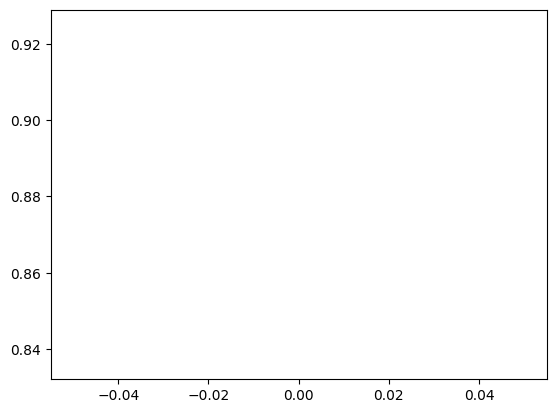

In [18]:
plt.plot(test_outputs[10])
plt.plot(targets[10])
plt.legend(['pred', 'target'])

In [43]:
# Build plots
ys = None
y_hats = None
y_hat_outs = None
for i, (x, y) in enumerate(test_loader):
    # Only collect 1 samples

    x = x.to(model.device)
    y = y.to(model.device)
    with torch.no_grad():
        y_hat = model(x)
        y_hat_out = torch.round(y_hat)
        
    if ys is None:
        ys = y.view(-1)
        y_hats = y_hat.view(-1)
        y_hat_outs = y_hat_out.view(-1)
    else:
        ys = torch.cat([ys, y.view(-1)], dim=0)
        y_hats = torch.cat([y_hats, y_hat.view(-1)], dim=0)
        y_hat_outs = torch.cat([y_hat_outs, y_hat_out.view(-1)], dim=0)
    

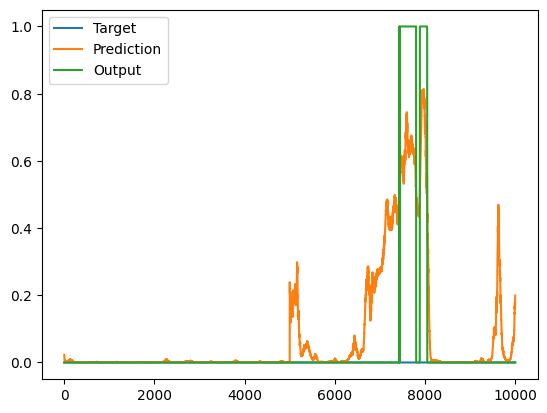

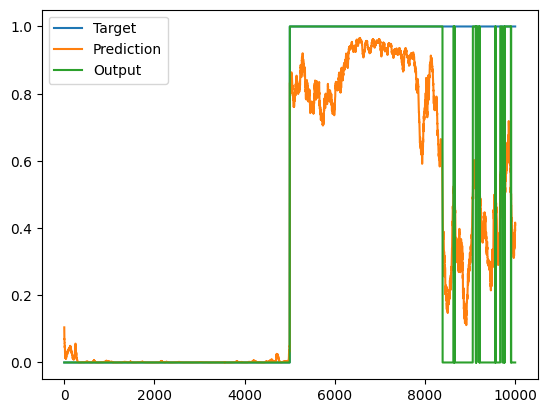

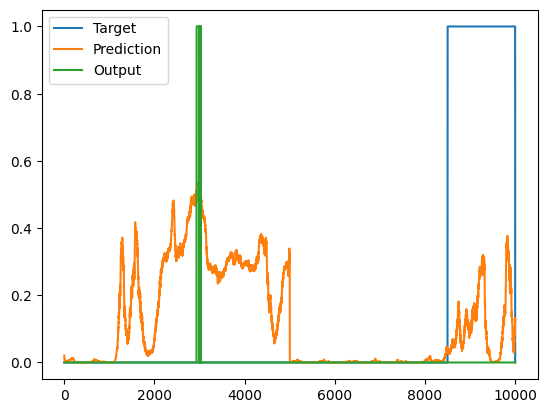

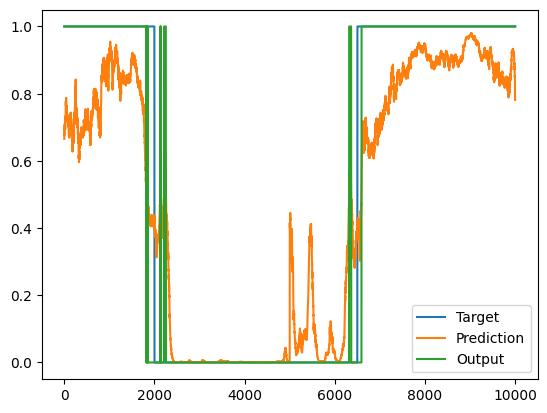

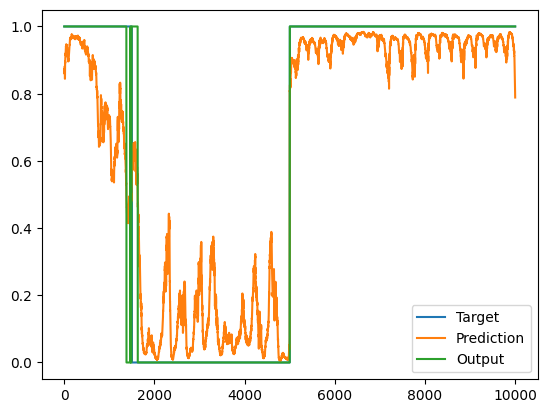

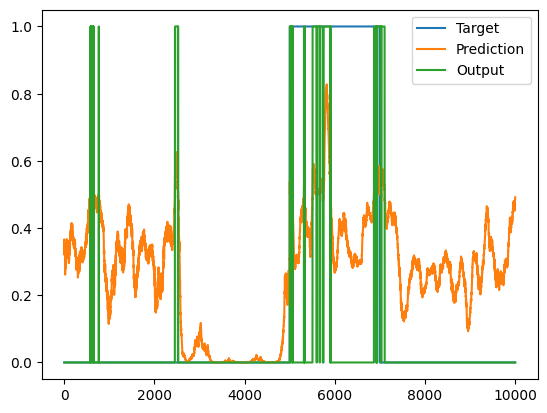

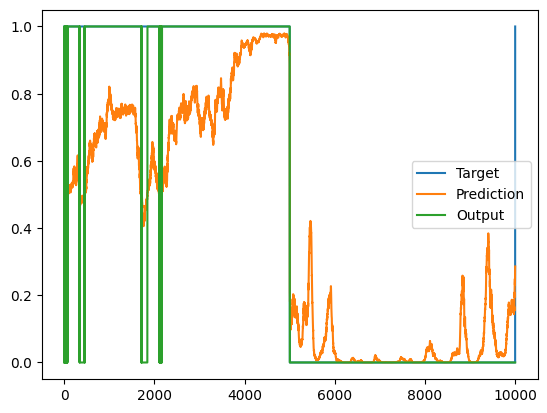

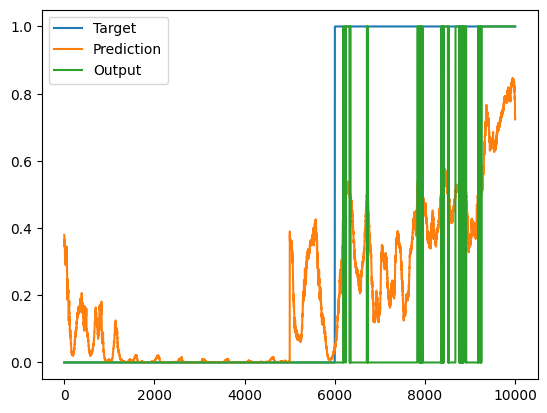

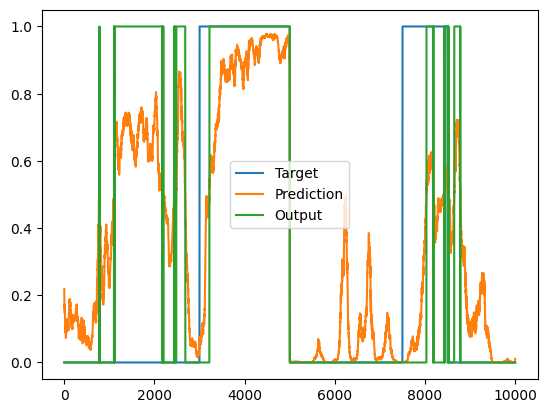

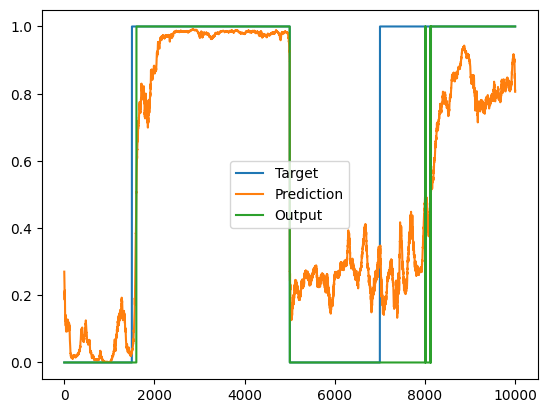

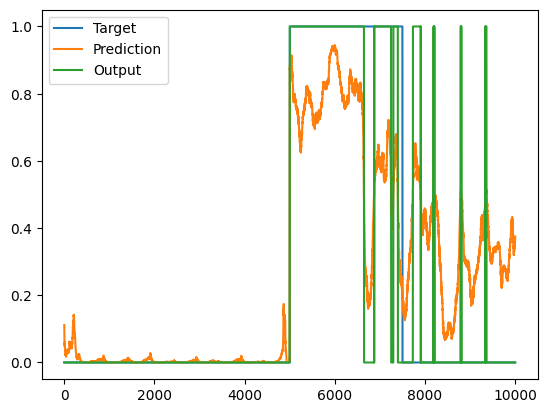

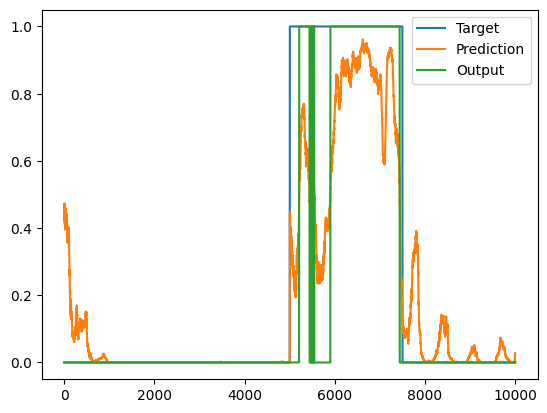

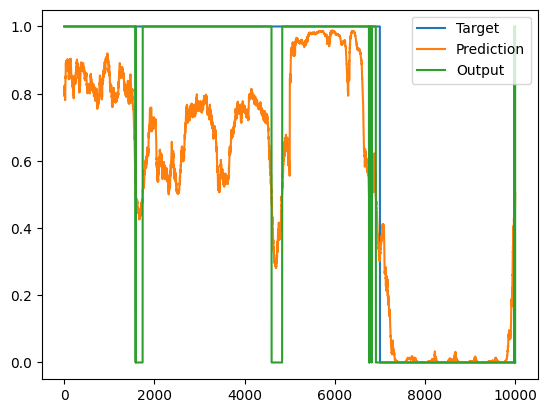

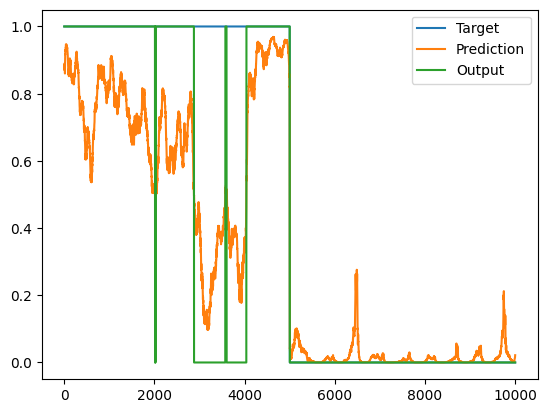

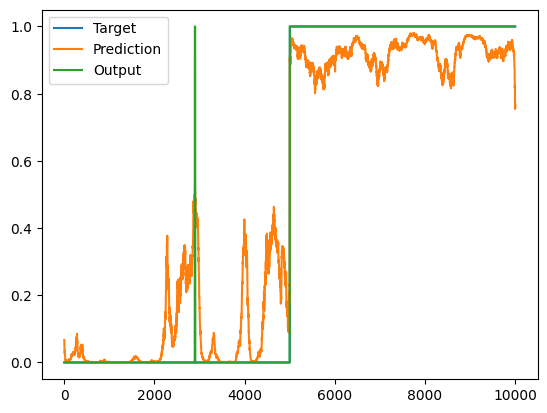

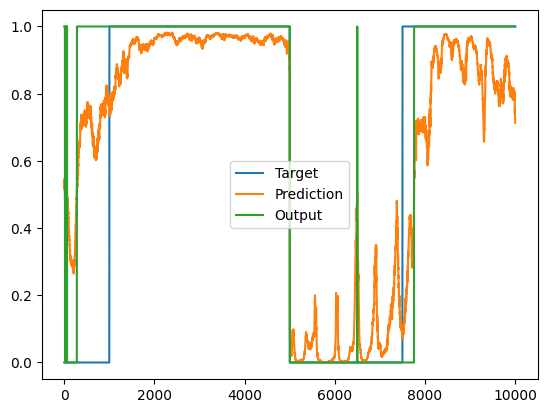

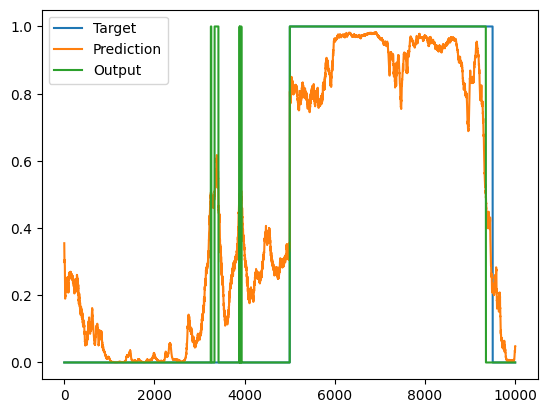

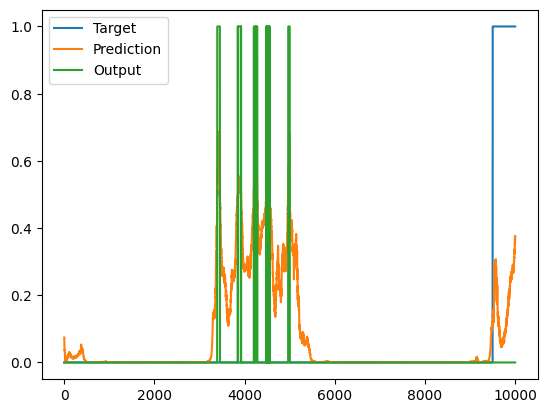

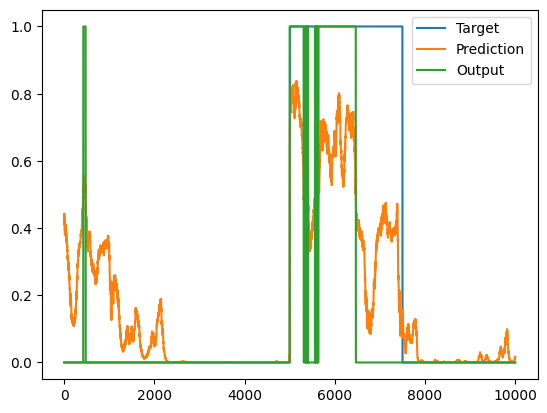

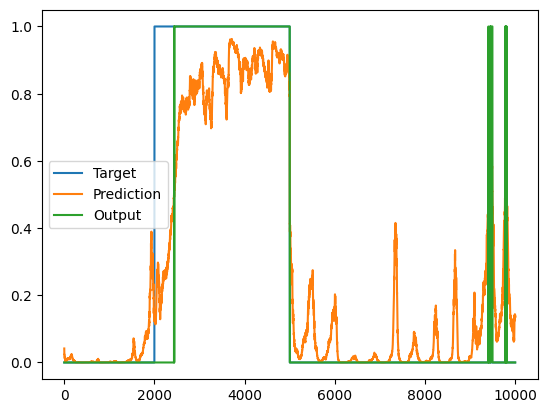

In [44]:
plot_window_size=10000
for i in range(20):
    plt.figure()
    plt.plot(ys[plot_window_size*i:plot_window_size*i+plot_window_size].cpu())
    plt.plot(y_hats[plot_window_size*i:plot_window_size*i+plot_window_size].cpu())
    plt.plot(y_hat_outs[plot_window_size*i:plot_window_size*i+plot_window_size].cpu())
    plt.legend(['Target', 'Prediction','Output'])